missions:
- log(rate) vs reaction energy
- log(rate) vs. reaction energy & degree (leaf reduction)

In [72]:
import sys; sys.path.append("../")
from src.SimulatedReactionGraph import SimulatedReactionGraph
import torinanet as tn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import stats

In [ ]:
reaction_energy = lambda g, rxn: g.get_properties(rxn)["energy"]
reaction_molrank = lambda g, rxn: g.get_properties(rxn)["molrank"]
reaction_max_rate = lambda g, rxn: max(g.get_properties(rxn)["rate"])
reaction_sum_degree = lambda g, rxn: np.sum([len(g.creating_reactions(sp)) for sp in g.get_reactants(rxn)])
reaction_prod_degree = lambda g, rxn: np.prod([len(g.creating_reactions(sp)) for sp in g.get_reactants(rxn)])

specie_energy = lambda g, sp: g.get_properties(sp)["energy"]
specie_molrank = lambda g, sp: g.get_properties(sp)["molrank"]
specie_distance = lambda g, sp: g.get_properties(sp)["sp_distance"]
specie_energy_distance = lambda g, sp: g.get_properties(sp)["abs_energy_distance"]
specie_total_energy_distance = lambda g, sp: g.get_properties(sp)["total_energy_distance"]
specie_in_degree = lambda g, sp: len(g.creating_reactions(sp))
specie_out_degree = lambda g, sp: len(g.consuming_reactions(sp))
specie_ss_conc = lambda g, sp: g.get_properties(sp)["concentration"][-1]
specie_max_conc = lambda g, sp: max(g.get_properties(sp)["concentration"])


def molrank_reactions(g: SimulatedReactionGraph):
    rxngraph = g.to_rxngraph()
    molrank = tn.analyze.network_reduction.KineticReduction.MolRankReduction(rank_th=0, rate_constant_property="k", estimate_max_constants=False)
    df = molrank.rank_reactions(rxngraph)
    for rxn in g.get_reactions():
        g.get_properties(rxn)["molrank"] = df.loc[rxn, "p"]
    return g

def molrank_species(g: SimulatedReactionGraph):
    rxngraph = g.to_rxngraph()
    molrank = tn.analyze.network_reduction.KineticReduction.MolRankReduction(rank_th=0, rate_constant_property="k", estimate_max_constants=False)
    df = molrank.rank_species(rxngraph)
    for sp in g.get_species():
        g.get_properties(sp)["molrank"] = df.loc[sp, "p"]
    return g

def shortest_path(g: SimulatedReactionGraph):
    rxngraph = g.to_rxngraph()
    dist_analyzer = tn.analyze.algorithms.ShortestPathAnalyzer(rxngraph, prop_func=lambda rxn: 1)
    energy_analyzer = tn.analyze.algorithms.ShortestPathAnalyzer(rxngraph, prop_func=lambda rxn: max(rxn.properties["energy"], 0))
    for sp in rxngraph.species:
        g.get_properties(sp.identifier)["sp_distance"] = dist_analyzer.shortest_path_table.loc[sp.identifier, "dist"]
        g.get_properties(sp.identifier)["abs_energy_distance"] = energy_analyzer.shortest_path_table.loc[sp.identifier, "dist"]
        g.get_properties(sp.identifier)["total_energy_distance"] = sum([r.properties["energy"] for r in energy_analyzer.get_path_to_source(sp)])
    return g


def property_df(g: SimulatedReactionGraph, properties: dict, target: str) -> pd.DataFrame:
    if target == "reactions": 
        objects = g.get_reactions()
    else:
        objects = g.get_species()
    data = []
    for obj in objects:
        ajr = [g.properties["path"]]
        for func in properties.values():
            ajr.append(func(g, obj))
        data.append(ajr)
    return pd.DataFrame(data, columns=["g"] + list(properties.keys()), index=objects)

def all_graph_files():
    ajr = []
    parent = "../data/simulated"
    for dirname in os.listdir(parent):
        p = os.path.join(parent, dirname)
        for fname in os.listdir(p):
            ajr.append(os.path.join(p, fname))

    return ajr

In [87]:
gfiles = all_graph_files()
# gfiles = np.random.choice(gfiles, 5, replace=False)
# gfiles = ["../data/simulated/s50r2500/{}.json".format(i) for i in range(5)]
# gfiles = [gfiles[0]]
rxnproperties = {
    "energy": reaction_energy,
    "sum_degree": reaction_sum_degree,
    "prod_degree": reaction_prod_degree,
    "max_rate": reaction_max_rate,
    # "molrank": reaction_molrank
}

spproperties = {
    "energy": specie_energy,
    "distance": specie_distance,
    "energy_distance": specie_energy_distance,
    "total_energy_distance": specie_total_energy_distance,
    "in_degree": specie_in_degree,
    "out_degree": specie_out_degree,
    "ss_concentration": specie_ss_conc,
    "max_concentration": specie_max_conc
    # "molrank": specie_molrank,
}

rxndfs = []
spdfs = []
for path in gfiles:
    print(path)
    g = SimulatedReactionGraph.from_file(path)
    g.properties["path"] = path
    # g = molrank_reactions(g)
    # g = molrank_species(g)
    g = shortest_path(g)
    rxndfs.append(property_df(g, rxnproperties, "reactions"))
    spdfs.append(property_df(g, spproperties, "species"))

rdf = pd.concat(rxndfs)
sdf = pd.concat(spdfs)

../data/simulated/s50r5000/0.json
../data/simulated/s50r5000/4.json
../data/simulated/s50r5000/2.json
../data/simulated/s50r5000/3.json
../data/simulated/s50r2500/0.json
../data/simulated/s50r2500/1.json
../data/simulated/s50r2500/4.json
../data/simulated/s50r2500/2.json
../data/simulated/s50r2500/3.json
../data/simulated/s25r5000/0.json
../data/simulated/s25r5000/1.json
../data/simulated/s25r5000/4.json
../data/simulated/s25r5000/2.json
../data/simulated/s25r5000/3.json
../data/simulated/s25r1000/0.json
../data/simulated/s25r1000/1.json
../data/simulated/s25r1000/4.json
../data/simulated/s25r1000/2.json
../data/simulated/s25r1000/3.json
../data/simulated/s50r1000/1.json
../data/simulated/s50r1000/4.json
../data/simulated/s50r1000/2.json
../data/simulated/s50r1000/3.json
../data/simulated/s100r5000/4.json
../data/simulated/s25r2500/0.json
../data/simulated/s25r2500/1.json
../data/simulated/s25r2500/4.json
../data/simulated/s25r2500/2.json
../data/simulated/s25r2500/3.json


,id,N,r/s,avg_degree,median_degree,slope,intercept,r^2
4,20.0,200,20.0,39.9,29.0,-1.5,3.7,0.9
3,40.0,125,40.0,79.8,72.0,-1.8,6.2,0.8
1,50.0,350,50.0,99.9,74.0,-1.6,5.8,0.9
0,100.0,325,100.0,199.8,158.0,-2.2,10.1,0.8
2,200.0,125,200.0,399.7,428.0,-0.5,0.6,0.3


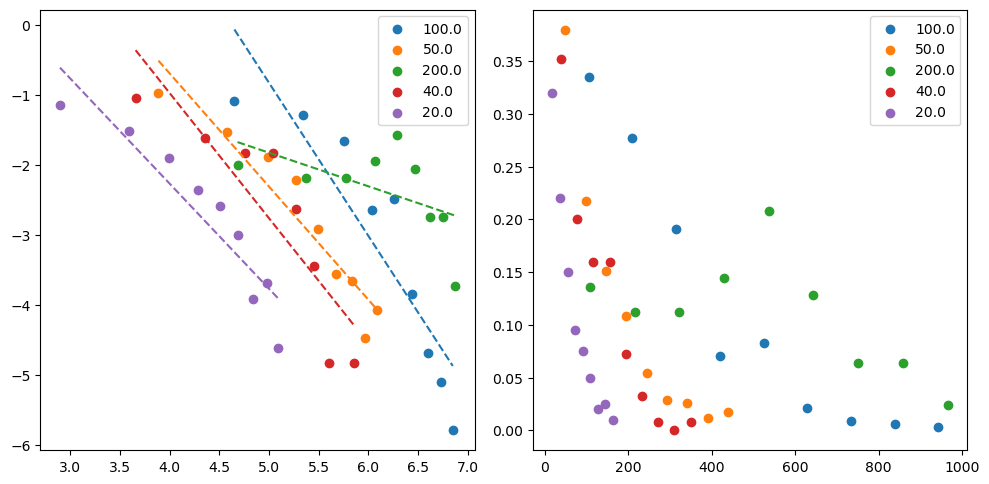

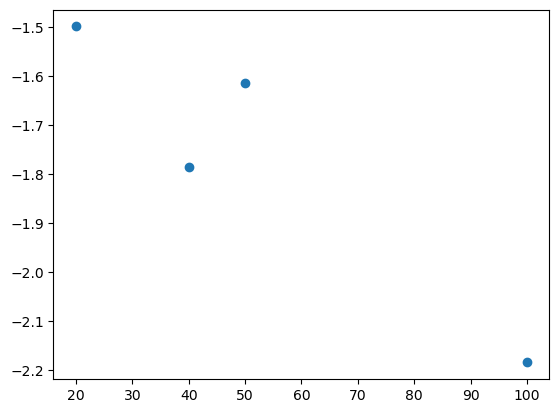

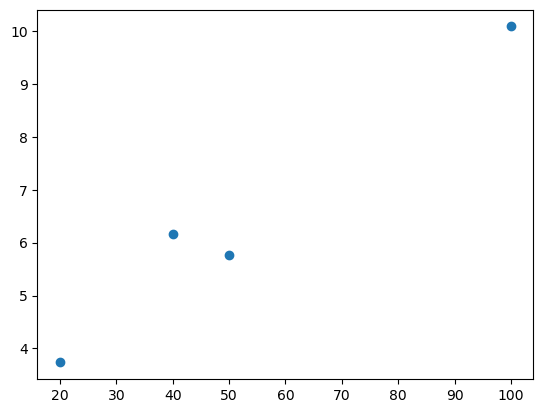

In [88]:

sdf["nspecies"] = [int(p.split('/')[-2].split("r")[0][1:]) for p in sdf["g"]]
sdf["nreactions"] = [int(p.split('/')[-2].split("r")[-1]) for p in sdf["g"]]
sdf["r/s"] = sdf["nreactions"] / sdf["nspecies"]
sdf["rs"] = ["s{}r{}".format(s, r) for s, r in zip(sdf["nspecies"], sdf["nreactions"])]
sdf["total_degree"] = sdf["in_degree"] + sdf["out_degree"]
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
plt.tight_layout()
data = []
key = "r/s"
c = "out_degree"
for ratio in sdf[key].unique():
    d = {}
    ajr = sdf[sdf[key] == ratio].copy()
    d["id"] = ratio
    d["N"] = len(ajr)
    d["r/s"] = ajr["r/s"].mean()
    d["avg_degree"] = ajr[c].mean()
    d["median_degree"] = ajr[c].median()
    values = np.linspace(ajr[c].min(), ajr[c].max(), 10)
    pdf = np.diff(np.array([np.sum(ajr[c] <= v) / len(ajr) for v in values]))
    x = np.array([np.log(k) for k, a in zip(values[1:], pdf) if a > 0 ])
    y = np.array([np.log(a) for a in pdf if a > 0])
    axs[0].scatter(x, y, label=ratio)
    a, b = np.polyfit(x, y, deg=1)
    d['slope'] = a
    d['intercept'] = b
    d['r^2'] = stats.pearsonr(x, y).correlation ** 2
    color = axs[0]._get_lines.get_next_color()
    axs[0].plot(x, a * x + b, color=color, linestyle="--")
    axs[1].scatter(values[1:], pdf, label=ratio)
    data.append(d)
axs[0].legend()
axs[1].legend()
df = pd.DataFrame(data).sort_values("r/s")
plt.figure()
ajr = df.iloc[:-1, :]
plt.scatter(ajr["r/s"], ajr["slope"])
plt.figure()
plt.scatter(ajr["r/s"], ajr["intercept"])
df.round(1)

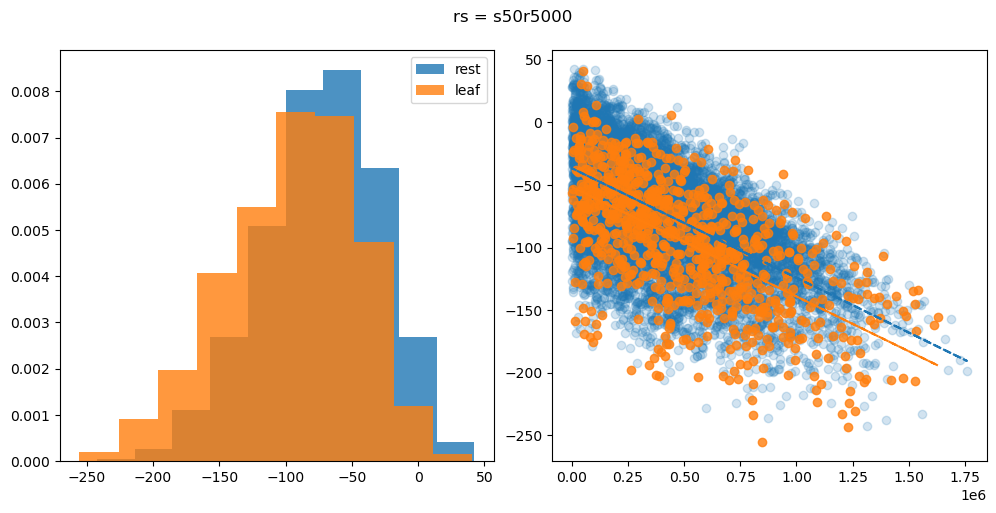

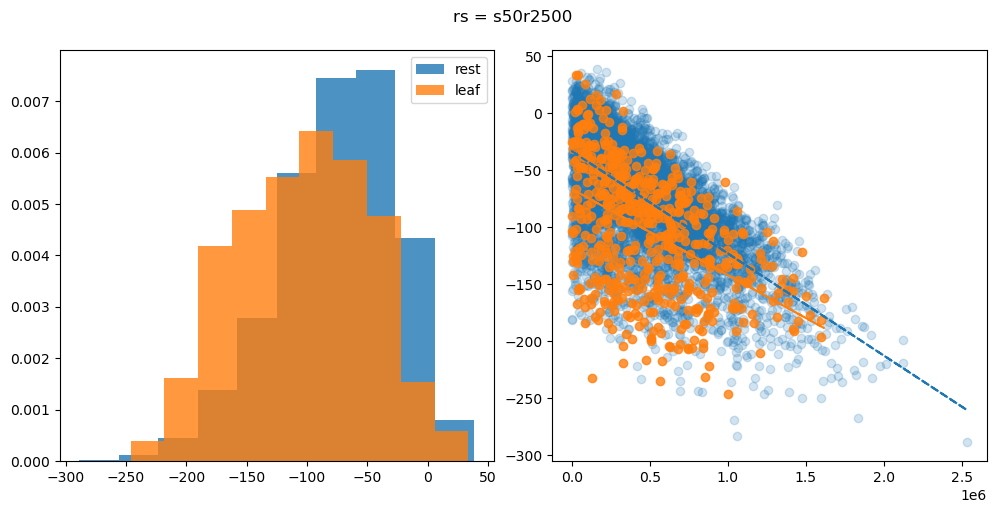

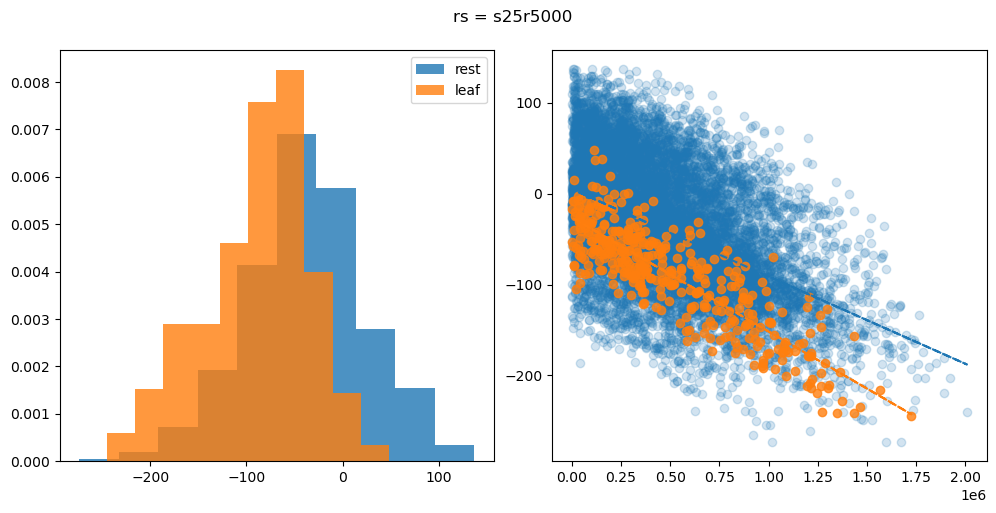

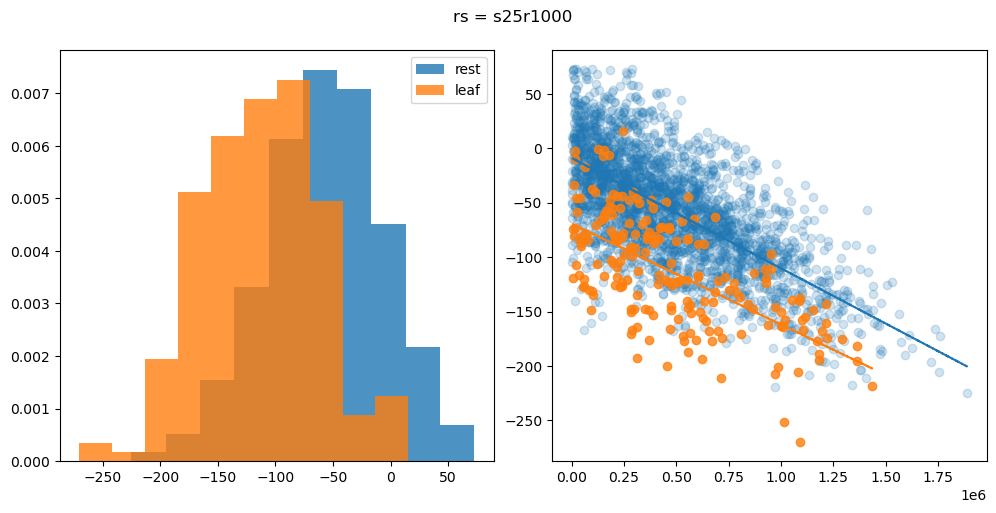

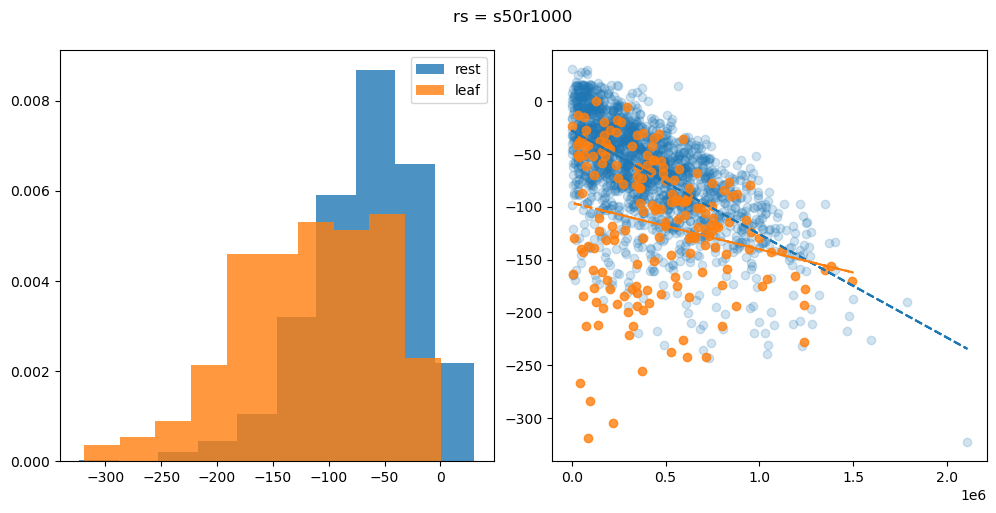

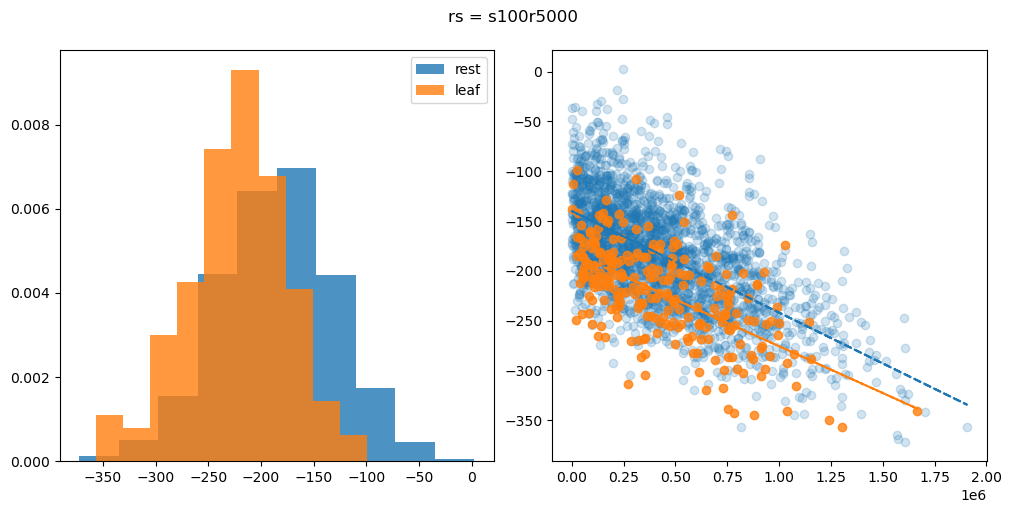

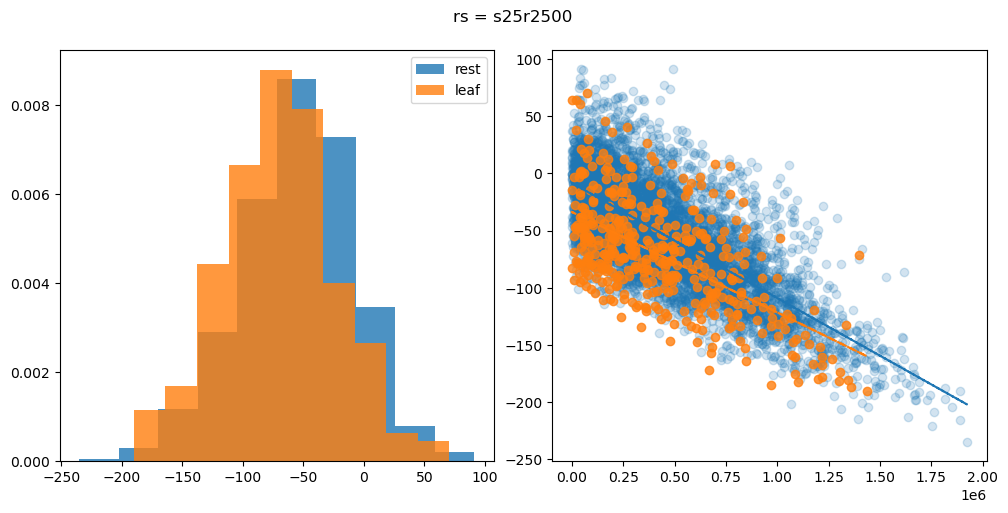

In [117]:
rdf["nspecies"] = [int(p.split('/')[-2].split("r")[0][1:]) for p in rdf["g"]]
rdf["nreactions"] = [int(p.split('/')[-2].split("r")[-1]) for p in rdf["g"]]
rdf["r/s"] = rdf["nreactions"] / rdf["nspecies"]
rdf["rs"] = ["s{}r{}".format(s, r) for s, r in zip(rdf["nspecies"], rdf["nreactions"])]
key = "rs"
data = []
for v in rdf[key].unique():
    d = {"id": v}
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
    fig.suptitle("{} = {}".format(key, v))
    plt.tight_layout()
    ajr = rdf[(rdf[key] == v) & (rdf["energy"] > 0)].copy()
    d["N"] = len(ajr)
    ajr["log_max_rate"] = np.log(ajr["max_rate"])
    rs_ratio = ajr["r/s"].mean()
    d["r/s"] = rs_ratio
    leafs = ajr[ajr["sum_degree"] < rs_ratio]
    rest = ajr[ajr["sum_degree"] >= rs_ratio]
    axs[0].hist(rest["log_max_rate"], alpha=0.8, label="rest", density=True)
    axs[0].hist(leafs["log_max_rate"], alpha=0.8, label="leaf", density=True)
    axs[0].legend()
    res = stats.linregress(rest["energy"], rest["log_max_rate"])
    d["rest_mean"] = rest["log_max_rate"].mean()
    d["rest_N"] = len(rest)
    d["rest_slope"] = res.slope
    d["rest_intercept"] = res.intercept
    d["rest_rsquared"] = res.rvalue ** 2
    color = axs[1]._get_lines.get_next_color()
    axs[1].scatter(rest["energy"], rest["log_max_rate"], alpha=0.2, c=color)
    axs[1].plot(rest["energy"], res.slope * rest["energy"] + res.intercept, color=color, linestyle="--")
    res = stats.linregress(leafs["energy"], leafs["log_max_rate"])
    d["leaf_mean"] = leafs["log_max_rate"].mean()
    d["leaf_N"] = len(leafs)
    d["leaf_slope"] = res.slope
    d["leaf_intercept"] = res.intercept
    d["leaf_rsquared"] = res.rvalue ** 2
    color = axs[1]._get_lines.get_next_color()
    axs[1].scatter(leafs["energy"], leafs["log_max_rate"], alpha=0.8, c=color)
    axs[1].plot(leafs["energy"], res.slope * leafs["energy"] + res.intercept, color=color, linestyle="--")
    axs[1].plot()
    d["leaf_rest_diff_pval"] = stats.ttest_ind(leafs["log_max_rate"], rest["log_max_rate"], equal_var=False)[-1]
    data.append(d)
df = pd.DataFrame(data)

In [118]:
df

,id,N,r/s,rest_mean,rest_N,rest_slope,rest_intercept,rest_rsquared,leaf_mean,leaf_N,leaf_slope,leaf_intercept,leaf_rsquared,leaf_rest_diff_pval
0,s50r5000,11020,100.0,-72.954123,10166,-0.000087,-36.708887,0.356937,-94.906256,854,-0.000087,-51.644727,0.373066,3.436449e-33
1,s50r2500,6324,50.0,-75.121607,5768,-0.000089,-33.426968,0.405611,-103.092867,556,-0.000075,-66.483182,0.224784,9.536408e-28
2,s25r5000,13412,200.0,-37.350023,13011,-0.000096,4.923791,0.262105,-89.078525,401,-0.000126,-26.121558,0.717666,2.112748e-55
3,s25r1000,2835,40.0,-56.691393,2637,-0.000101,-8.861633,0.452847,-113.441432,198,-0.000093,-69.216360,0.409778,4.826394e-36
4,s50r1000,1974,20.0,-67.686072,1797,-0.000098,-27.853336,0.376049,-116.434078,177,-0.000044,-96.288673,0.048085,9.597901e-19
5,s100r5000,2504,50.0,-184.497110,2258,-0.000102,-140.005568,0.367258,-222.726011,246,-0.000094,-181.847802,0.371245,1.079177e-26
6,s25r2500,6444,100.0,-54.853401,6012,-0.000101,-8.333393,0.532003,-70.771260,432,-0.000088,-33.645679,0.361741,4.087226e-11


Text(0, 0.5, 'Energy Difference (Rest - Leaf)')

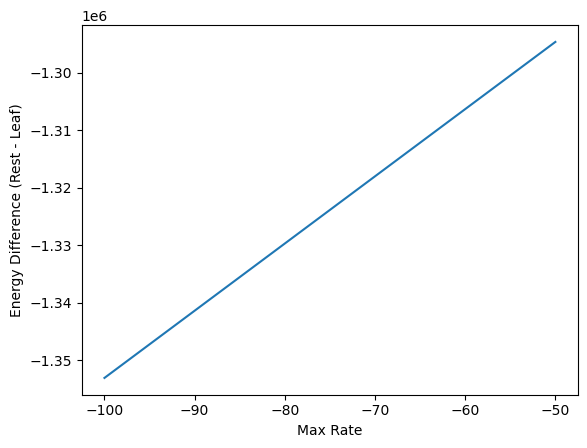

In [111]:
rates = np.linspace(-50, -100, 100)
difference = 1 / df["rest_slope"].mean() * rates - df["rest_intercept"].mean() / df["rest_slope"].mean() - (1 / df["leaf_slope"].mean() * rates + df["leaf_intercept"].mean() / df["leaf_slope"].mean())
plt.figure()
plt.plot(rates, difference)
plt.xlabel("Max Rate")
plt.ylabel("Energy Difference (Rest - Leaf)")

In [ ]:
plt.scatter(sdf["energy_distance"], sdf["max_concentration"])
plt.yscale("log")

In [ ]:
plt.scatter(rdf["energy"], np.log10(rdf["max_rate"]), alpha=0.2)
plt.figure()
plt.scatter(rdf["degree"], np.log10(rdf["max_rate"]), alpha=0.2)
plt.figure()
plt.yscale("log")
plt.scatter(rdf["degree"], rdf["energy"], c=np.log10(rdf["max_rate"]), cmap="Greens", alpha=0.2)
ajr = rdf[rdf["energy"] > 0]
plt.scatter(ajr["energy"], ajr["max_rate"], alpha=0.2)
ajr = ajr[ajr["degree"] < 50]
plt.scatter(ajr["energy"], ajr["max_rate"], alpha=0.2)

# Real networks

In [176]:
from src.NasaPolynomial import NasaPolynomial
from src import constants
import json
from openbabel import openbabel as ob
import sqlite3
constants.DEFAULT_TEMPERATURE = 1000

In [183]:

def get_energy(connection, smiles):
    l = connection.execute("SELECT energy FROM species WHERE smiles=\"{}\"".format(smiles)).fetchall()
    if len(l) > 0:
        return l[0][0]
    else:
        return None

def get_atomization_energy(connection, smiles: str, atom_energies: dict):
    if smiles is None:
        return None
    # read smiles
    conv = ob.OBConversion()
    conv.SetInFormat("smi")
    obmol = ob.OBMol()
    conv.ReadString(obmol, smiles)
    obmol.AddHydrogens()
    # get single atom energy
    ajr = 0
    for atom in ob.OBMolAtomIter(obmol):
        ajr += atom_energies[ob.GetSymbol(atom.GetAtomicNum())]
    e = get_energy(connection, smiles)
    if e is not None:
        return e - ajr
    else:
        return None

def add_atomization_energies(db_path: str, rxn_graph: tn.core.RxnGraph) -> tn.core.RxnGraph:
    """Method to update the species energies in the reaction graph from existing computations"""
    connection = sqlite3.connect(db_path)
    atom_energies = {
                     "H": get_energy(connection, "[H]"), 
                     "O": get_energy(connection, "[O]"), 
                     "C": get_energy(connection, "[C]"),
                     "N": get_energy(connection, "[N]")
                    }
    # adding data to species
    for specie in rxn_graph.species:
        smiles = specie.identifier 
        atomization_energy = get_atomization_energy(connection, smiles, atom_energies)
        if atomization_energy is not None:
            specie.properties["energy"] = atomization_energy * constants.Ha_TO_JMOL
    connection.close()
    return rxn_graph

def add_specie_enthalpy(rxn_graph: tn.core.RxnGraph):
    for sp in rxn_graph.species:
        s = sp.properties["thermo"].replace("'", "\"")
        d = json.loads(s)
        poly = NasaPolynomial(**d)
        sp.properties["energy"] = poly.h(constants.DEFAULT_TEMPERATURE)
    return rxn_graph    

def add_reaction_energy(rxn_graph: tn.core.RxnGraph, energy_property: str) -> tn.core.RxnGraph:
    # adding data to reactions
    for rxn in rxn_graph.reactions:
        products_e = [s.properties.get(energy_property, None) for s in rxn.products]
        reactants_e = [s.properties.get(energy_property, None) for s in rxn.reactants]
        if None in products_e or None in reactants_e:
            continue
        rxn.properties["energy"]  = sum(products_e) - sum(reactants_e)
    return rxn_graph

def add_rate_constants(g: tn.core.RxnGraph):
    for rxn in g.reactions:
        A = rxn.properties["A"]
        beta = rxn.properties["beta"]
        Ea = rxn.properties["Ea"]
        T = constants.DEFAULT_TEMPERATURE
        rxn.properties["k"] = A * T ** beta * np.exp(- Ea / (T * constants.R))
    return g

def add_kinetics(g: tn.core.RxnGraph, **kwargs):
    g = add_rate_constants(g)
    solver = tn.analyze.kinetics.KineticAnalyzer(g, "k")
    iconcs = [1 if s in g.source_species else 0 for s in g.species]
    solver.solve_kinetics(iconcs, **kwargs)
    for rxn in g.reactions:
        rxn.properties["max_rate"] = solver.get_max_rate(rxn)
    return g

def add_shortest_path(g: tn.core.RxnGraph):
    dist_analyzer = tn.analyze.algorithms.ShortestPathAnalyzer(g, prop_func=lambda rxn: 1)
    energy_analyzer = tn.analyze.algorithms.ShortestPathAnalyzer(g, prop_func=lambda rxn: max(rxn.properties["energy"], 0))
    for sp in g.species:
        sp.properties["sp_distance"] = dist_analyzer.shortest_path_table.loc[sp.identifier, "dist"]
        sp.properties["abs_energy_distance"] = energy_analyzer.shortest_path_table.loc[sp.identifier, "dist"]
        sp.properties["total_energy_distance"] = sum([r.properties["energy"] for r in energy_analyzer.get_path_to_source(sp)])
    return g

def add_rxn_properties(g: tn.core.RxnGraph):
    G = g.to_networkx_graph(use_internal_id=True)
    for rxn in g.reactions:
        degrees = [len(list(G.successors(g.specie_collection.get_key(sp)))) for sp in rxn.reactants]
        rxn.properties["sum_degree"] = np.sum(degrees)
        rxn.properties["prod_degree"] = np.prod(degrees)
    return g

def add_specie_properties(g: tn.core.RxnGraph):
    G = g.to_networkx_graph(use_internal_id=True)
    for sp in g.species:
        sp.properties["in_degree"] = len(list(G.predecessors(g.specie_collection.get_key(sp))))
        sp.properties["out_degree"] = len(list(G.successors(g.specie_collection.get_key(sp))))
    return g

def add_properties(g: tn.core.RxnGraph):
    g = add_specie_enthalpy(g)
    g = add_kinetics(g)
    g = add_reaction_energy(g, "energy")
    g = add_shortest_path(g)
    g = add_rxn_properties(g)
    g = add_specie_properties(g)
    return g

def species_df(g: tn.core.RxnGraph, props):
    data = []
    for sp in g.species:
        data.append({p: sp.properties[p] for p in props})
    return pd.DataFrame(data, index=[sp.identifier for sp in g.species])

def reactions_df(g: tn.core.RxnGraph, props):
    data = []
    for rxn in g.reactions:
        data.append({p: rxn.properties[p] for p in props})
    return pd.DataFrame(data, index=[rxn.pretty_string() for rxn in g.reactions])


In [184]:
ajr = []
# ps = [os.path.join(constants.DATA_DIR, "enumerated", "raw", "ammonia", "2", "crud_graph.rxn")]
ps = ["ammonia", "methane"]
for p in ps:
    g = tn.core.RxnGraph.from_file(constants.BASE_LITERATURE_GRAPH_PATH.replace("$", p), constants.RXN_GRAPH_PARAMS)
    # g = tn.core.RxnGraph.from_file(p)
    nreactions = g.get_n_reactions()
    nspecies = g.get_n_species()
    g = add_properties(g)
    rdf = reactions_df(g, ["energy", "sum_degree", "prod_degree", "max_rate"])
    rdf["g"] = p
    rdf["nspecies"] = nspecies
    rdf["nreactions"] = nreactions
    sdf = species_df(g, ["energy", "sp_distance", "abs_energy_distance", "total_energy_distance", "in_degree", "out_degree"])
    sdf["g"] = p
    sdf["nspecies"] = nspecies
    sdf["nreactions"] = nreactions
    ajr.append([rdf, sdf])
rdf = pd.concat([a[0] for a in ajr])
sdf = pd.concat([a[1] for a in ajr])

,id,N,r/s,rest_mean,rest_N,rest_slope,rest_intercept,rest_rsquared,leaf_mean,leaf_N,leaf_slope,leaf_intercept,leaf_rsquared,leaf_rest_diff_pval
0,ammonia,235,15.666667,-12.277891,209,-0.000063,-0.310296,0.460807,-4.096649,26,-0.000066,12.612777,0.598441,2.185520e-02
1,methane,200,12.058824,-23.288501,178,-0.000067,-9.859974,0.381738,-5.177191,22,-0.000044,8.990415,0.434120,6.631196e-09


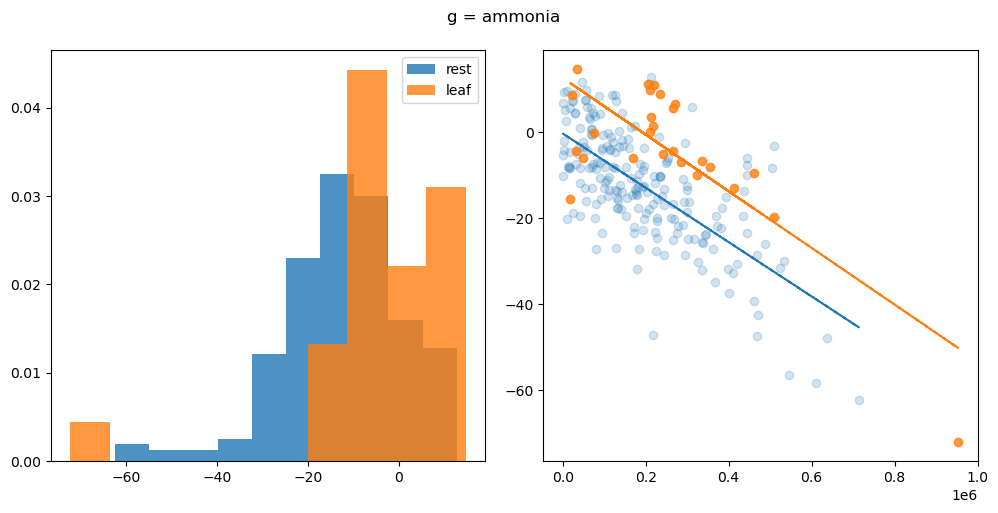

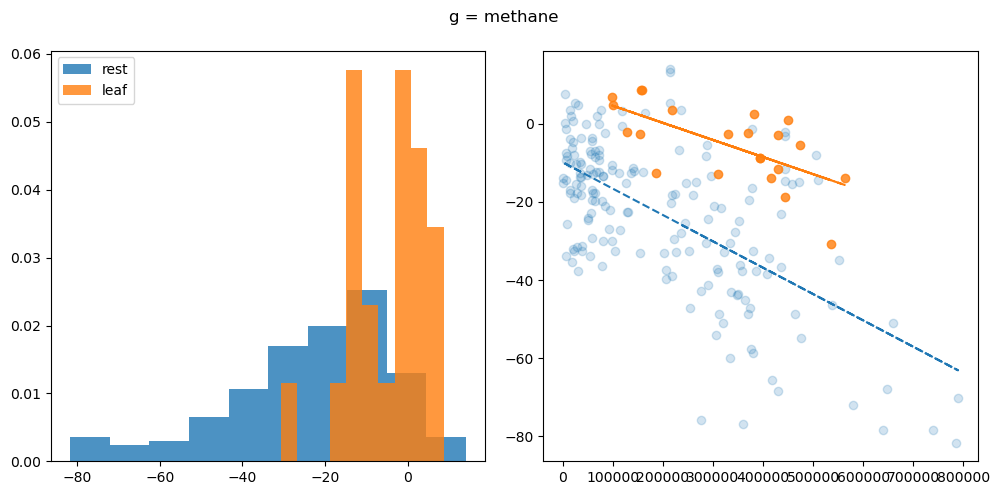

In [185]:
rdf["r/s"] = rdf["nreactions"] / rdf["nspecies"]
rdf["rs"] = ["s{}r{}".format(s, r) for s, r in zip(rdf["nspecies"], rdf["nreactions"])]
key = "g"
data = []
for v in rdf[key].unique():
    d = {"id": v}
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
    fig.suptitle("{} = {}".format(key, v))
    plt.tight_layout()
    ajr = rdf[(rdf[key] == v) & (rdf["energy"] > 0)].copy()
    d["N"] = len(ajr)
    ajr["log_max_rate"] = np.log(ajr["max_rate"])
    rs_ratio = ajr["r/s"].mean()
    d["r/s"] = rs_ratio
    leafs = ajr[ajr["sum_degree"] < rs_ratio * 2]
    rest = ajr[ajr["sum_degree"] >= rs_ratio * 2]
    axs[0].hist(rest["log_max_rate"], alpha=0.8, label="rest", density=True)
    axs[0].hist(leafs["log_max_rate"], alpha=0.8, label="leaf", density=True)
    axs[0].legend()
    res = stats.linregress(rest["energy"], rest["log_max_rate"])
    d["rest_mean"] = rest["log_max_rate"].mean()
    d["rest_N"] = len(rest)
    d["rest_slope"] = res.slope
    d["rest_intercept"] = res.intercept
    d["rest_rsquared"] = res.rvalue ** 2
    color = axs[1]._get_lines.get_next_color()
    axs[1].scatter(rest["energy"], rest["log_max_rate"], alpha=0.2, c=color)
    axs[1].plot(rest["energy"], res.slope * rest["energy"] + res.intercept, color=color, linestyle="--")
    res = stats.linregress(leafs["energy"], leafs["log_max_rate"])
    d["leaf_mean"] = leafs["log_max_rate"].mean()
    d["leaf_N"] = len(leafs)
    d["leaf_slope"] = res.slope
    d["leaf_intercept"] = res.intercept
    d["leaf_rsquared"] = res.rvalue ** 2
    color = axs[1]._get_lines.get_next_color()
    axs[1].scatter(leafs["energy"], leafs["log_max_rate"], alpha=0.8, c=color)
    axs[1].plot(leafs["energy"], res.slope * leafs["energy"] + res.intercept, color=color, linestyle="--")
    axs[1].plot()
    d["leaf_rest_diff_pval"] = stats.ttest_ind(leafs["log_max_rate"], rest["log_max_rate"], equal_var=False)[-1]
    data.append(d)
df = pd.DataFrame(data)
df

In [ ]:
# dangerous stuff - random percolation :()
for path in rdf["g"].unique():
    fig, axs = plt.subplots(ncols=2)
    ajr = rdf[rdf["g"] == path].sort_values("energy", ascending=True)
    ajr["covered_max_rate"] = 1 - ajr["max_rate"].cumsum() / ajr["max_rate"].sum()
    ajr["n_removed"] = range(1, len(ajr) + 1)
    nremoved = len(ajr) - ajr[ajr["covered_max_rate"] < 0.999]["energy"].count()
    axs[0].scatter(ajr["energy"], ajr["covered_max_rate"], alpha=0.2)
    # plt.scatter(ajr["energy"], ajr["covered_max_rate"], alpha=0.2)
    axs[1].scatter(ajr["n_removed"], ajr["covered_max_rate"], alpha=0.2)
    s = ajr["max_rate"].sum()
    trails = pd.DataFrame([[1 - sum(np.random.choice(ajr["max_rate"], n, replace=False)) / s for n in ajr["n_removed"]] for _ in range(20)], columns=ajr["n_removed"]).transpose()
    medians = trails.quantile(0.5, axis=1)
    axs[1].plot(ajr["n_removed"], medians, "k--", alpha=0.5)


: 